# Emoji Sentiment Analysis with Tweets
        
## step2-Data cleaning
### 2.1-First EDA
### 2.2-Data cleaning
        
    1. remove url
    2. remove user names
    3. remove punctuations
    4. remove stopwords
    5. lower the words
    6. lemmatization
    7. keep only english characters and emojis

### 2.3-Extract pure emojis and text   
And, we generate 3 new coloumns which:
- remove all emojis
        
----
- include all emojis
        
----
- only include concerned emojis

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTigQWzoYCNiDyrz1BN4WTf2X2k9OZ_yvW-FsmcIMsdS9fppNmh)


### 2.1 Exploratory Data Analysis

Our dataset consists of Tweets which contain at least one of the following emoji
The baseline selection of common-used emoji refers to [Ian D. Wood, Sebastian Ruder, 2016](https://www.researchgate.net/publication/321057905_Emoji_as_Emotion_Tags_for_Tweets)
        
The tag of emoji is besed on human intuition accroding to the original paper, instead of meaning in context.
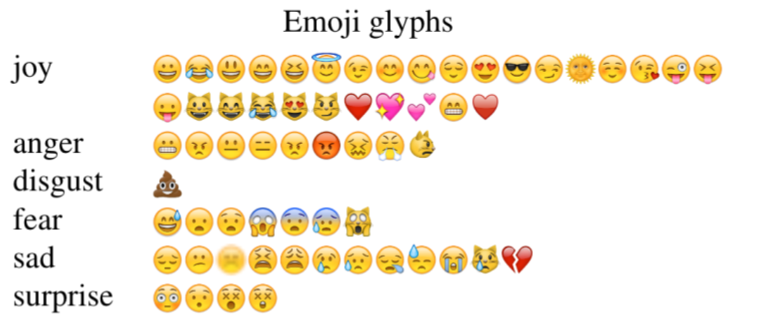

In [1]:
# required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string

In [2]:
# emoji lists

joy = ['\U0001F600', '\U0001F602', '\U0001F603', '\U0001F604',
          '\U0001F606', '\U0001F607', '\U0001F609', '\U0001F60A',
          '\U0001F60B', '\U0001F60C', '\U0001F60D', '\U0001F60E',
          '\U0001F60F', '\U0001F31E', '\U0000263A', '\U0001F618',
          '\U0001F61C', '\U0001F61D', '\U0001F61B', '\U0001F63A',
          '\U0001F638', '\U0001F639', '\U0001F63B', '\U0001F63C',
          '\U00002764', '\U0001F496', '\U0001F495', '\U0001F601',
          '\U00002665']#joy

anger = ['\U0001F62C', '\U0001F620', '\U0001F610',
          '\U0001F611', '\U0001F620', '\U0001F621', '\U0001F616',
          '\U0001F624', '\U0001F63E']#anger
disgust= ['\U0001F4A9']#disgust
fear = ['\U0001F605', '\U0001F626', '\U0001F627', '\U0001F631',
          '\U0001F628', '\U0001F630', '\U0001F640']#fear
sad = ['\U0001F614', '\U0001F615', '\U00002639', '\U0001F62B',
          '\U0001F629', '\U0001F622', '\U0001F625', '\U0001F62A',
          '\U0001F613', '\U0001F62D', '\U0001F63F', '\U0001F494']#sad
surp = ['\U0001F633', '\U0001F62F', '\U0001F635', '\U0001F632']#surprise

emojis = {'joy':joy, 'anger':anger, 'disgust':disgust, 'fear':fear, 'sad':sad, 'surprise':surp}
for i in emojis:
    print('There are {} emoji contains in the cluster {}'.format(len(emojis[i]), i))
    print(i,emojis[i])

There are 29 emoji contains in the cluster joy
joy ['😀', '😂', '😃', '😄', '😆', '😇', '😉', '😊', '😋', '😌', '😍', '😎', '😏', '🌞', '☺', '😘', '😜', '😝', '😛', '😺', '😸', '😹', '😻', '😼', '❤', '💖', '💕', '😁', '♥']
There are 9 emoji contains in the cluster anger
anger ['😬', '😠', '😐', '😑', '😠', '😡', '😖', '😤', '😾']
There are 1 emoji contains in the cluster disgust
disgust ['💩']
There are 7 emoji contains in the cluster fear
fear ['😅', '😦', '😧', '😱', '😨', '😰', '🙀']
There are 12 emoji contains in the cluster sad
sad ['😔', '😕', '☹', '😫', '😩', '😢', '😥', '😪', '😓', '😭', '😿', '💔']
There are 4 emoji contains in the cluster surprise
surprise ['😳', '😯', '😵', '😲']


In [3]:
#load the crawed data
tweet = pd.read_csv('tweets3.csv')
tweet = tweet[tweet.type != 'type']#due to mistake when scraping, some rows are written as header repeatedly by mistake
tweet = tweet.drop_duplicates()#drop duplicated rows
print('We crawed {} Tweets which contain at least one concerned emoji from 2022-04-15 to 2022-05-28:'.format(len(tweet)))
tweet

We crawed 366857 Tweets which contain at least one concerned emoji from 2022-04-15 to 2022-05-28:


,Unnamed: 0,id,time,tweets,source,entities,retweet,favorite,type
0,0,1517890741070143488,2022-04-23 15:38:48+00:00,😂😂😂😂😂😅 Everyone would be awake by the time I g...,Twitter for Android,"{'hashtags': [], 'symbols': [], 'user_mentions...",0.0,0.0,fear
1,1,1517890740705460231,2022-04-23 15:38:48+00:00,"RT @TheBigDome: Tag yourselves, we’re @imszmc ...",Twitter for Android,"{'hashtags': [], 'symbols': [], 'user_mentions...",355.0,0.0,fear
2,2,1517890738675191809,2022-04-23 15:38:47+00:00,@SnipesNFT @0xWave @BoredApeYC never unfortuna...,Twitter for iPhone,"{'hashtags': [], 'symbols': [], 'user_mentions...",0.0,0.0,fear
3,3,1517890737639149568,2022-04-23 15:38:47+00:00,RT @ESPNFC: FOUR GOALS FOR GABRIEL JESUS 😱 htt...,Twitter for iPhone,"{'hashtags': [], 'symbols': [], 'user_mentions...",229.0,0.0,fear
4,4,1517890736544530432,2022-04-23 15:38:47+00:00,RT @buitengebieden_: Kitten found the best spo...,Twitter for Android,"{'hashtags': [{'text': 'caturday', 'indices': ...",1022.0,0.0,fear
...,...,...,...,...,...,...,...,...,...
366852,385095,1528884215344795654,2022-05-23 23:42:56+00:00,RT @HotMessConserv2: A 13 year old boy is unde...,Twitter for iPhone,"{'hashtags': [], 'symbols': [], 'user_mentions...",6340.0,0.0,disgust
366853,385096,1528884192733372417,2022-05-23 23:42:51+00:00,expose yourself :\n\n1. I would rather slengka...,Twitter for Android,"{'hashtags': [], 'symbols': [], 'user_mentions...",0.0,0.0,disgust
366854,385097,1528884176363040773,2022-05-23 23:42:47+00:00,I just want the People Above My Pay Grade to h...,Twitter for iPhone,"{'hashtags': [], 'symbols': [], 'user_mentions...",0.0,1.0,disgust
366855,385098,1528884175302184960,2022-05-23 23:42:47+00:00,@tonytaslucas @JPFinlayNBCS @john_keim That’s ...,Twitter for iPhone,"{'hashtags': [], 'symbols': [], 'user_mentions...",0.0,0.0,disgust


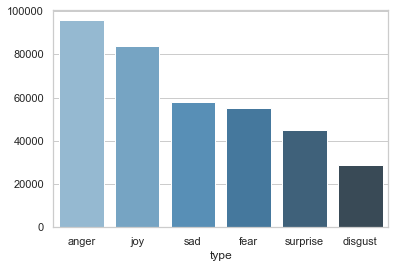

type
anger       95850
joy         84076
sad         57790
fear        55269
surprise    45178
disgust     28694
dtype: int64

In [4]:
# 2.1.1 data clusters contained in our dataset
# we considered the number of emoji in each cluster, as well as the balance of samples
sns.set(style="whitegrid", color_codes=True)
data = tweet.groupby("type").size().sort_values(ascending = False)
pal = sns.color_palette("Blues_d", len(data))
sns.barplot(x=data.index, y=data, palette=pal)

plt.show()
data

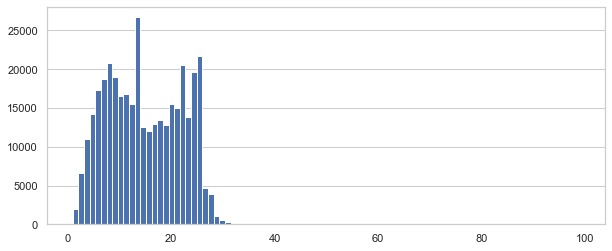

In [5]:
# 2.1.2 number of words in tweets
lengths = [len(t.split(' ')) for t in tweet['tweets']]

plt.figure(figsize=(10,4))
plt.grid(axis = 'x')
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

# most tweets contain words from 0 to 40
# Intuitively, this dosen't mean the longer tweets are outliers, we don't drop them so far
# but when taining models in the next section, we should consider the length distribution

In [6]:
# 2.1.3 find the common stopwords and punctuations in tweets

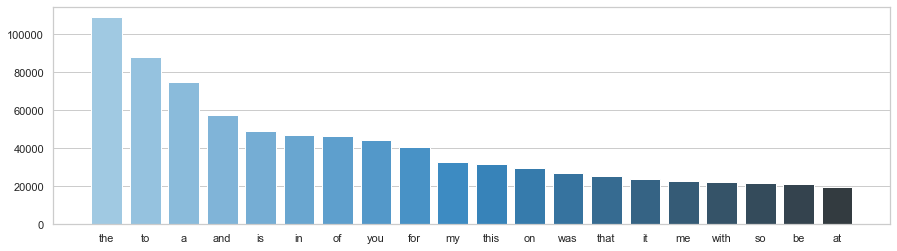

In [7]:
corpus=[]
for x in tweet['tweets'].str.split():
    for i in x:
        corpus.append(i)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20]
pal = sns.color_palette("Blues_d", len(top))
x,y=zip(*top)
plt.figure(figsize=(15,4))
plt.grid(axis = 'x')
plt.bar(x,y,color=pal)
plt.show()

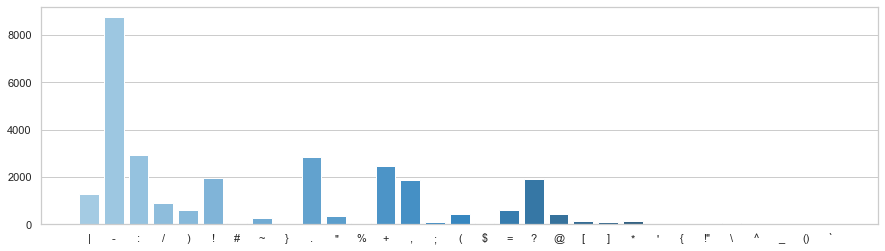

In [8]:
# punctuations
dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
pal = sns.color_palette("Blues_d", len(dic.items()))
plt.figure(figsize=(15,4))
plt.grid(axis = 'x')
plt.bar(x,y,color=pal)
plt.show()


### 2.2 Data Cleaning
We include 6 data cleaning steps:
        
    1. remove url
    2. remove user names
    3. remove punctuations
    4. remove stopwords
    5. lower the words
    6. lemmatization

Then, we construct a new column which remove all emoji for the future modeling

In [9]:
################

In [10]:
# 2.2.1 data cleaning
# a new dataframe, keep the original dataset
df = pd.read_csv('tweets3.csv')
df = df[df.type != 'type']

In [11]:
# i. remove url
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

example = df['tweets'][4]
print('Example of original Tweet:')
print(example)
print('---------------')
print('Removing url...')
example = remove_URL(example)
print(example)

df['tweets']=df['tweets'].apply(lambda x : remove_URL(x))

Example of original Tweet:
RT @buitengebieden_: Kitten found the best spot.. 😅

#caturday https://t.co/6SgrPCAv4A
---------------
Removing url...
RT @buitengebieden_: Kitten found the best spot.. 😅

#caturday 


In [12]:
# ii. remove user names
def remove_name(text):
    name=re.compile(r'R?T?.*?@\S+')
    return name.sub(r'',text)

example = df['tweets'][4]
# example = "RT @XtraSweetBobby: It's crazy we'll have a nice day and then like 3 days in a row where the wind is just blowing hard… "
print('Example of original Tweet:')
print(example)
print('---------------')
print('Removing user names...')
example = remove_name(example)
print(example)


Example of original Tweet:
RT @buitengebieden_: Kitten found the best spot.. 😅

#caturday 
---------------
Removing user names...
 Kitten found the best spot.. 😅

#caturday 


In [13]:
df['tweets']=df['tweets'].apply(lambda x : remove_name(x))

In [14]:
# iii. remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example = df['tweets'][4]
print('Example of original Tweet:')
print(example)
print('---------------')
print('Removing punctuations...')
example = remove_punct(example)
print(example)

df['tweets']=df['tweets'].apply(lambda x : remove_punct(x))

Example of original Tweet:
 Kitten found the best spot.. 😅

#caturday 
---------------
Removing punctuations...
 Kitten found the best spot 😅

caturday 


In [15]:
# iv. remove stopwords
from gensim.parsing.preprocessing import remove_stopwords
example = df['tweets'][4]
print('Example of original Tweet:')
print(example)
print('---------------')
print('Removing stopwords...')
example = remove_stopwords(example)
print(example)

df['tweets']=df['tweets'].apply(lambda x : remove_stopwords(x))

Example of original Tweet:
 Kitten found the best spot 😅

caturday 
---------------
Removing stopwords...
Kitten best spot 😅 caturday


In [16]:
# v. lower
example = df['tweets'][4]
print('Example of original Tweet:')
print(example)
print('---------------')
print('Lowering ...')
example = example.lower()
print(example)

df['tweets']=df['tweets'].apply(lambda x : x.lower())

Example of original Tweet:
Kitten best spot 😅 caturday
---------------
Lowering ...
kitten best spot 😅 caturday


In [17]:
#v.i. lemmatization

from textblob import TextBlob

def lemm(text):
    textTB = TextBlob(text)
    words = textTB.words
    words_lemmatized = words.lemmatize()
    return ' '.join(words_lemmatized)

example = df['tweets'][4]+' tweets'+' looks'
print('Example of original Tweet:')
print(example)
print('---------------')
print('Lemmatizating ...')
example = lemm(example)
print(example)

Example of original Tweet:
kitten best spot 😅 caturday tweets looks
---------------
Lemmatizating ...
kitten best spot 😅 caturday tweet look


In [18]:
%time df['tweets']=df['tweets'].apply(lambda x : lemm(x))

CPU times: user 1min 7s, sys: 351 ms, total: 1min 7s
Wall time: 1min 8s


In [19]:
# v.ii. keep only english characters and emojis

In [20]:
import emoji
import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())

def keepengemoji(text):
    ls = []
    for w in text.split(' '):
        if w in words:
            ls.append(w)
        elif w in emoji.UNICODE_EMOJI['en']:
            w = ' '+w+' '
            ls.append(w)
        else:
            continue
    return ' '.join(ls)

example = df['tweets'][4]+'我 们 لغة عربية 123 😅😅'
print('Example of original Tweet:')
print(example)
print('---------------')
print('Extracting English words and emojis ...')
example = keepengemoji(example)
print(example)

Example of original Tweet:
kitten best spot 😅 caturday我 们 لغة عربية 123 😅😅
---------------
Extracting English words and emojis ...
kitten best spot  😅 


[nltk_data] Error loading words: <urlopen error [Errno 61] Connection
[nltk_data]     refused>


In [21]:
df['tweets']=df['tweets'].apply(lambda x : keepengemoji(x))

### 2.3. Extract pure text and emojis

In [22]:
################
# i. Form a new column (pure text)

In [23]:
# function of removing emoji
import emoji

def remove_emojis(text):
  return ''.join(c for c in text if c not in emoji.UNICODE_EMOJI['en'])

example = df['tweets'][4]
print('Example of original Tweet:')
print(example)
print('---------------')
print('Extracting pure text ...')
example = remove_emojis(example)
print(example)

Example of original Tweet:
kitten best spot  😅 
---------------
Extracting pure text ...
kitten best spot   


In [24]:
puretext = [remove_emojis(t) for t in df['tweets']]
puretext[:10]

['everyone awake time i room',
 '',
 'unfortunately',
 'four goal for   ',
 'kitten best spot   ',
 '',
 'they looking wrong i hate',
 'you guy play time',
 'challenge community voting is officially you we second look',
 '']

In [25]:
# function of extracting emoji
import emoji

def extract_emojis(text):
  return ' '.join(c for c in text if c in emoji.UNICODE_EMOJI['en'])

example = df['tweets'][4]+'😅😅😅😅😅'
print('Example of original Tweet:')
print(example)
print('---------------')
print('Extracting emoji ...')
example = extract_emojis(example)
print(example)

Example of original Tweet:
kitten best spot  😅 😅😅😅😅😅
---------------
Extracting emoji ...
😅 😅 😅 😅 😅 😅


In [26]:
emojis = [extract_emojis(t) for t in df['tweets']]
emojis[:10]

['', '', '', '😱', '😅', '', '', '', '', '']

In [27]:
# function of get concerned emojis
allemoji = joy + anger + disgust + fear + sad + surp

def concern_emojis(text):
  return ' '.join(c for c in text if c in allemoji)

example = df['tweets'][59]+'😱🥶 💨 🖼🥳'
print('Example of original Tweet:')
print(example)
print('---------------')
print('Extracting concerned emoji ...')
example = concern_emojis(example)
print(example)


Example of original Tweet:
same play different jordan  😱 😱🥶 💨 🖼🥳
---------------
Extracting concerned emoji ...
😱 😱


In [28]:
c_emojis = [concern_emojis(t) for t in df['tweets']]
c_emojis[:10]

['', '', '', '😱', '😅', '', '', '', '', '']

In [29]:
# a new df
df2 = df
df2['puretext'] = puretext
df2['emojis'] = emojis
df2['c_emojis'] = c_emojis
df2[['time','tweets','puretext','emojis','c_emojis','type']]

,time,tweets,puretext,emojis,c_emojis,type
0,2022-04-23 15:38:48+00:00,everyone awake time i room,everyone awake time i room,,,fear
1,2022-04-23 15:38:48+00:00,,,,,fear
2,2022-04-23 15:38:47+00:00,unfortunately,unfortunately,,,fear
3,2022-04-23 15:38:47+00:00,four goal for 😱,four goal for,😱,😱,fear
4,2022-04-23 15:38:47+00:00,kitten best spot 😅,kitten best spot,😅,😅,fear
...,...,...,...,...,...,...
366852,2022-05-23 23:42:56+00:00,a year old boy sexual harassment investigation...,a year old boy sexual harassment investigation...,,,disgust
366853,2022-05-23 23:42:51+00:00,expose i maybe black p,expose i maybe black p,,,disgust
366854,2022-05-23 23:42:47+00:00,i want people above my pay grade energy giving...,i want people above my pay grade energy giving...,,,disgust
366855,2022-05-23 23:42:47+00:00,that s fan endure going it s 💩,that s fan endure going it s,💩,💩,disgust


In [30]:
# # some emojis in tweets are removed due to text processing
df2.query('emojis == ""')

,Unnamed: 0,id,time,tweets,source,entities,retweet,favorite,type,puretext,emojis,c_emojis
0,0,1517890741070143488,2022-04-23 15:38:48+00:00,everyone awake time i room,Twitter for Android,"{'hashtags': [], 'symbols': [], 'user_mentions...",0.0,0.0,fear,everyone awake time i room,,
1,1,1517890740705460231,2022-04-23 15:38:48+00:00,,Twitter for Android,"{'hashtags': [], 'symbols': [], 'user_mentions...",355.0,0.0,fear,,,
2,2,1517890738675191809,2022-04-23 15:38:47+00:00,unfortunately,Twitter for iPhone,"{'hashtags': [], 'symbols': [], 'user_mentions...",0.0,0.0,fear,unfortunately,,
5,5,1517890736141733888,2022-04-23 15:38:47+00:00,,Twitter for iPhone,"{'hashtags': [], 'symbols': [], 'user_mentions...",0.0,0.0,fear,,,
6,6,1517890735772774400,2022-04-23 15:38:47+00:00,they looking wrong i hate,Twitter for iPhone,"{'hashtags': [], 'symbols': [], 'user_mentions...",0.0,0.0,fear,they looking wrong i hate,,
...,...,...,...,...,...,...,...,...,...,...,...,...
366850,385093,1528884298560204800,2022-05-23 23:43:16+00:00,your source statement or making,Twitter for iPad,"{'hashtags': [{'text': 'WhitePowerBarbie', 'in...",0.0,5.0,disgust,your source statement or making,,
366852,385095,1528884215344795654,2022-05-23 23:42:56+00:00,a year old boy sexual harassment investigation...,Twitter for iPhone,"{'hashtags': [], 'symbols': [], 'user_mentions...",6340.0,0.0,disgust,a year old boy sexual harassment investigation...,,
366853,385096,1528884192733372417,2022-05-23 23:42:51+00:00,expose i maybe black p,Twitter for Android,"{'hashtags': [], 'symbols': [], 'user_mentions...",0.0,0.0,disgust,expose i maybe black p,,
366854,385097,1528884176363040773,2022-05-23 23:42:47+00:00,i want people above my pay grade energy giving...,Twitter for iPhone,"{'hashtags': [], 'symbols': [], 'user_mentions...",0.0,1.0,disgust,i want people above my pay grade energy giving...,,


In [31]:
# example of mistook data
i = 17
print(tweet.loc[i]['tweets'])
print(df.loc[i]['tweets'])
print(df2.loc[i]['tweets'])

print('---------')
print('we now delete these samples')

@XtraSweetBobby It's crazy we'll have a nice day and then like 3 days in a row where the wind is just blowing hard… https://t.co/EdQaWQ67u7
it crazy nice day like day row wind blowing
it crazy nice day like day row wind blowing
---------
we now delete these samples


In [32]:
# we need to drop these invalid samples
df3 = df2[df2.emojis != '']
df3[['time','tweets','puretext','emojis','type']]

,time,tweets,puretext,emojis,type
3,2022-04-23 15:38:47+00:00,four goal for 😱,four goal for,😱,fear
4,2022-04-23 15:38:47+00:00,kitten best spot 😅,kitten best spot,😅,fear
11,2022-04-23 15:38:46+00:00,🙀 when cleaning window remember,when cleaning window remember,🙀,fear
13,2022-04-23 15:38:45+00:00,diamond dragon field day making fun 😅,diamond dragon field day making fun,😅,fear
14,2022-04-23 15:38:45+00:00,😅,,😅,fear
...,...,...,...,...,...
366839,2022-05-23 23:43:58+00:00,t 💩 talk,t talk,💩,disgust
366845,2022-05-23 23:43:45+00:00,you expect b 💩 😖 look 😡 black face,you expect b look black face,💩 😖 😡,disgust
366846,2022-05-23 23:43:42+00:00,💩 never use crap,never use crap,💩,disgust
366851,2022-05-23 23:43:06+00:00,what 💩,what,💩,disgust


In [33]:
df3[['tweets','puretext','emojis','c_emojis']]

,tweets,puretext,emojis,c_emojis
3,four goal for 😱,four goal for,😱,😱
4,kitten best spot 😅,kitten best spot,😅,😅
11,🙀 when cleaning window remember,when cleaning window remember,🙀,🙀
13,diamond dragon field day making fun 😅,diamond dragon field day making fun,😅,😅
14,😅,,😅,😅
...,...,...,...,...
366839,t 💩 talk,t talk,💩,💩
366845,you expect b 💩 😖 look 😡 black face,you expect b look black face,💩 😖 😡,💩 😖 😡
366846,💩 never use crap,never use crap,💩,💩
366851,what 💩,what,💩,💩


In [34]:
###
# split multi-emojis in tweets
import emoji
def emosplit(text):
    words = []
    for c in text:
        if c in emoji.UNICODE_EMOJI['en']:
            c = ' '+c+' '
            words.append(c)
        else:
            words.append(c)
    return ''.join(words)

example = df2['tweets'][3]
print('Example of original Tweet:')
print(example)
print('---------------')
print('Spliting emojis...')
example = emosplit(example)
print(example)

Example of original Tweet:
four goal for  😱 
---------------
Spliting emojis...
four goal for   😱  


In [35]:
stext = [emosplit(t) for t in df3['tweets']]
stext[:10]

['four goal for   😱  ',
 'kitten best spot   😅  ',
 '  🙀   when cleaning window remember',
 'diamond dragon field day making fun   😅  ',
 '  😅  ',
 'quick giveaway sorry late   😅   winner peso like tweet following',
 'same play different jordan   😱  ',
 '  😮   big news   😮   the team officially begun build phase we pushing',
 '  💙   purposely singing badly   ❤ ️  somebody bring guy   😅  ',
 'statue   😅  ']

In [36]:
df3['stweets'] = stext
df3[['time','stweets','tweets','puretext','emojis','c_emojis','type']]

<ipython-input-36-05627c022991>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['stweets'] = stext


,time,stweets,tweets,puretext,emojis,c_emojis,type
3,2022-04-23 15:38:47+00:00,four goal for 😱,four goal for 😱,four goal for,😱,😱,fear
4,2022-04-23 15:38:47+00:00,kitten best spot 😅,kitten best spot 😅,kitten best spot,😅,😅,fear
11,2022-04-23 15:38:46+00:00,🙀 when cleaning window remember,🙀 when cleaning window remember,when cleaning window remember,🙀,🙀,fear
13,2022-04-23 15:38:45+00:00,diamond dragon field day making fun 😅,diamond dragon field day making fun 😅,diamond dragon field day making fun,😅,😅,fear
14,2022-04-23 15:38:45+00:00,😅,😅,,😅,😅,fear
...,...,...,...,...,...,...,...
366839,2022-05-23 23:43:58+00:00,t 💩 talk,t 💩 talk,t talk,💩,💩,disgust
366845,2022-05-23 23:43:45+00:00,you expect b 💩 😖 look 😡 black face,you expect b 💩 😖 look 😡 black face,you expect b look black face,💩 😖 😡,💩 😖 😡,disgust
366846,2022-05-23 23:43:42+00:00,💩 never use crap,💩 never use crap,never use crap,💩,💩,disgust
366851,2022-05-23 23:43:06+00:00,what 💩,what 💩,what,💩,💩,disgust


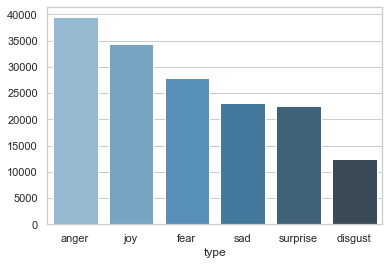

type
anger       39476
joy         34393
fear        27920
sad         23144
surprise    22607
disgust     12501
dtype: int64

In [37]:
################
# 2.2.3 Look at the parsed dataset

sns.set(style="whitegrid", color_codes=True)
data = df3.groupby("type").size().sort_values(ascending = False)
pal = sns.color_palette("Blues_d", len(data))
sns.barplot(x=data.index, y=data, palette=pal)

plt.show()
data

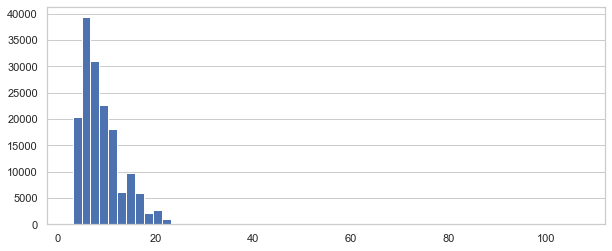

In [38]:
# number of words in tweets
lengths = [len(t.split(' ')) for t in df3['tweets']]

plt.figure(figsize=(10,4))
plt.grid(axis = 'x')
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

# after data cleaning,
# most tweets contain words from 0 to 25

In [39]:
# save new csvs
df3.to_csv('tweets_cleaned_drop.csv')

In [40]:
# upload to github version
df4 = df3[['time','tweets','stweets','puretext','emojis','c_emojis','type']]
df4.to_csv('data_tweets_cleaned_en.csv')